##### The University of Melbourne, School of Computing and Information Systems

**COMP30027 Machine Learning, 2022 Semester 1**

---

# **Assignment 2:** Sentiment Classification of Tweets

---

In [4]:
## Import all necessary modules for:
# general use
import pandas as pd
from collections import Counter
# plotting
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# feature extraction
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# classification
# evaluation

# set the plot font sizes
# ref: https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 26
MEDIUM_SIZE = 30
BIGGER_SIZE = 34
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

[nltk_data] Downloading package stopwords to C:\Users\Xavier
[nltk_data]     Travers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Raw Data Analysis

A shallow analysis of the dataset.

### Importing the data

In [5]:
train_df = pd.read_csv("../data/Train.csv", sep=',')
test_df = pd.read_csv("../data/Test.csv", sep=',')

### Basic Information
Specifically the types of the data and the lengths of each set.

In [6]:
# get information about types in the training set
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21802 entries, 0 to 21801
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  21802 non-null  int64 
 1   id          21802 non-null  int64 
 2   text        21802 non-null  object
 3   sentiment   21802 non-null  object
dtypes: int64(2), object(2)
memory usage: 681.4+ KB


In [7]:
# get information about types in the testing set
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6099 entries, 0 to 6098
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6099 non-null   int64 
 1   text    6099 non-null   object
dtypes: int64(1), object(1)
memory usage: 95.4+ KB


### Inspecting Instances 
To verify what they look like when `pandas` imports them.

In [8]:
# inspect the head of the training information
train_df.head()

,Unnamed: 0,id,text,sentiment
0,2,805582613687713000,doctors hit campaign trail as race to medical...,neutral
1,3,637480203497832000,is anybody going to the radio station tomorro...,positive
2,4,641096279930507000,i just found out naruto didn't become the 5th...,neutral
3,5,625730917647126000,"""prince george reservist who died saturday ju...",neutral
4,6,633292370906230000,season in the sun versi nirvana rancak gak..s...,positive


In [9]:
# inspect the head of the testing information
test_df.head()

,id,text
0,802217876644052000,@loogunda @poroshenko putin abducted ukrainia...
1,802425296955682000,if putin wanted to intervene all he would hav...
2,805664502515662000,@hillbuzz @gaypatriot elsewhere in progland.....
3,639928670103015000,any females copping the gucci foamposites tom...
4,673824182287904000,"""in other news, had a great saturday on the t..."


In [10]:
# show a random sample from the training information
train_df.sample(5)

,Unnamed: 0,id,text,sentiment
19436,24752,800591965318475000,"@realdonaldtrump screw romney, try this guy fo...",neutral
12424,15887,640090076035317000,listened to foo fighters - cold day in the su...,neutral
15962,20494,802211594465734000,@johnnyspectator @davidcorndc @alexburnsnyt w...,neutral
4160,5322,673988566389678000,"""@theladyloki1 thor shook his head, """"i may ...",neutral
19809,25267,624917540343410000,"@hyunseunghips ah really? thankyou~ not yet, m...",positive


In [11]:
# show a random sample from the testing information
test_df.sample(5)

,id,text
5699,641310161534099000,that's us signing off. tweeting resumes from 7...
2439,805588269324910000,live and let die? resources for your #euthanas...
1980,640156614046171000,the new super eagles goalkeeper is the reason...
4585,802413719699550000,earlier on thursday samsung teased us with a ...
1242,632342129621225000,david price is lucky so far...nowhere near th...


### Distribution of Sentiments

There may be a majority sentiment in the `Train.csv`.

Counter({'neutral': 12659, 'positive': 5428, 'negative': 3715})


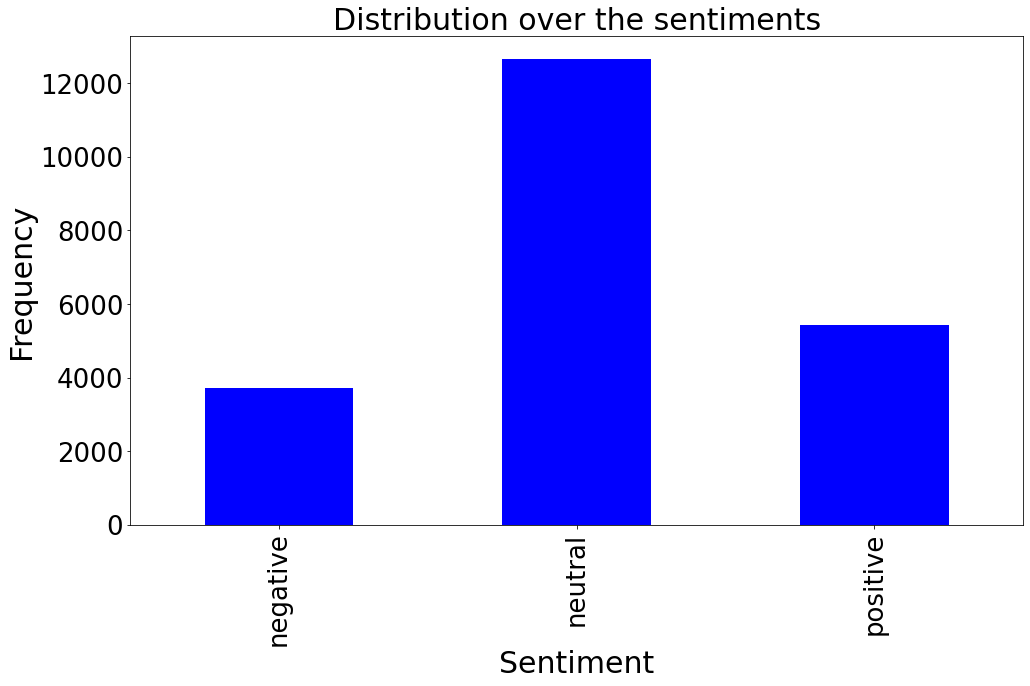

In [17]:
# Sentiment options and counts
print(Counter(train_df[['sentiment']].values[:, 0]))

# Distribution of the data between the sentiments
train_df.groupby('sentiment').count().plot.bar(legend=False, figsize=(16, 9), color='blue')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution over the sentiments')
plt.savefig('../report/img/sentiment-distribution.png', bbox_inches='tight')

## 2. Data Preprocessing

Functionality for cleaning the text data

### Cleaning Functionality
A simple cleaning function for the data with modifiable features.

In [10]:
## pre-cache the regex
# common tweet feature regex
RE_LINKS = re.compile(r'https?://t.co/\w*')
RE_HASHTAGS = re.compile(r'(?<=\W)#\w*[a-z]\w*')
RE_MENTIONS = re.compile(r'(?<=\W)@\w+')
# other re
RE_REPEATED_CONSECUTIVES = re.compile(r'(.)\1+')
RE_NUMBERS = re.compile(r'\d+')
RE_NON_ALPHANUMERIC = re.compile(r'[^a-z]+')

# list of different terms to clean
DEFAULT_CLEAN_DICT = {
    'links': True,
    'hashtags': False,
    'mentions': True,
    'numbers': True,
    'non-alphanumeric': True,
    'repeated-consecutive': False,
    'stopwords': None, # removing stopwords
}

# a function to selectively clean different terms within tweets
def clean_tweet(tweet: str, remove: dict = DEFAULT_CLEAN_DICT) -> str:
    new_tweet = tweet
    if remove['links']: new_tweet = RE_LINKS.sub(' ', new_tweet)
    if remove['hashtags']: new_tweet = RE_HASHTAGS.sub(' ', new_tweet)
    if remove['mentions']: new_tweet = RE_MENTIONS.sub(' ', new_tweet)
    if remove['repeated-consecutive']: new_tweet = RE_REPEATED_CONSECUTIVES.sub(r'\1', new_tweet)
    if remove['numbers']: new_tweet = RE_NUMBERS.sub(' ', new_tweet)
    if remove['non-alphanumeric']: 
        new_tweet = RE_NON_ALPHANUMERIC.sub(' ', new_tweet)
    if remove['stopwords'] is not None:
        re_stopwords = re.compile(r'\b(' + r'|'.join(remove['stopwords']) + r')\b\s*')
        new_tweet = re_stopwords.sub(' ', new_tweet)

    # remove unnecessary space characters
    new_tweet = re.sub(r' +', ' ', new_tweet)
    new_tweet = re.sub(r'^ | $', '', new_tweet) # bookend spaces
    return new_tweet

# apply the default cleaning function to the training and test sets
train_df['text-clean-default'] = train_df['text'].apply(clean_tweet)
test_df['text-clean-default'] = test_df['text'].apply(clean_tweet)

# inspect a sample of the training information and compare the clean and raw tweets
train_df.sample(5)

,Unnamed: 0,id,text,sentiment,text-clean-default
21161,27077,638196116526366000,i feel like so much happened on the vmas. kan...,positive,i feel like so much happened on the vmas kanye...
8018,10237,623153383730352000,"""and thank you for stopping by, dustin johnso...",neutral,and thank you for stopping by dustin johnson m...
10910,13937,635171661050982000,"""following his defeat to the undertaker tomor...",neutral,following his defeat to the undertaker tomorro...
5140,6544,801787803541576000,has #obama ever apologized for the terrorists...,negative,has obama ever apologized for the terrorists a...
16597,21285,675892781831888000,21-14 them with 4:14 to go. milan scampers fo...,neutral,them with to go milan scampers for one on th down


### Identifying Stopwords
Words with little value to be removed

Word cloud for all-clean-default
Word cloud for positive-clean-default
Word cloud for neutral-clean-default
Word cloud for negative-clean-default


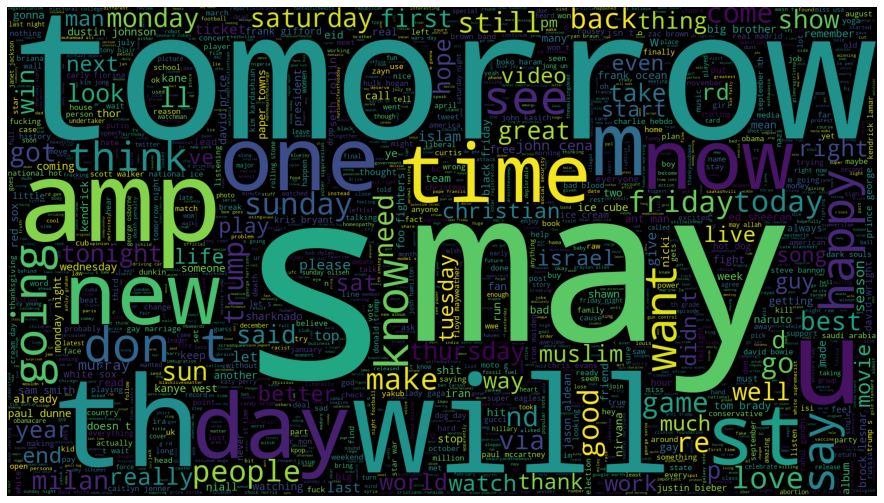

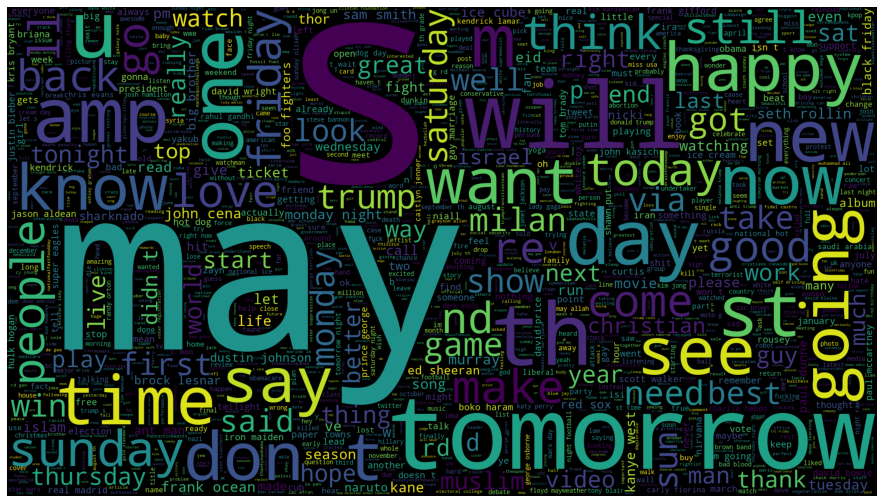

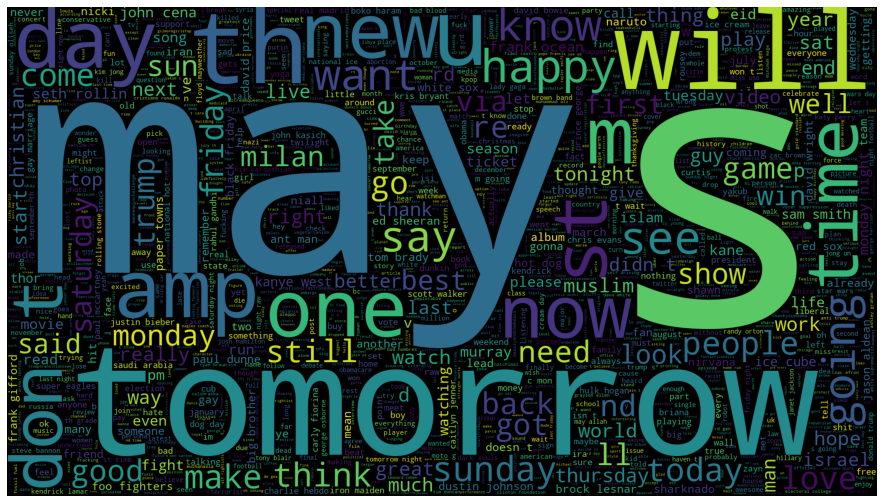

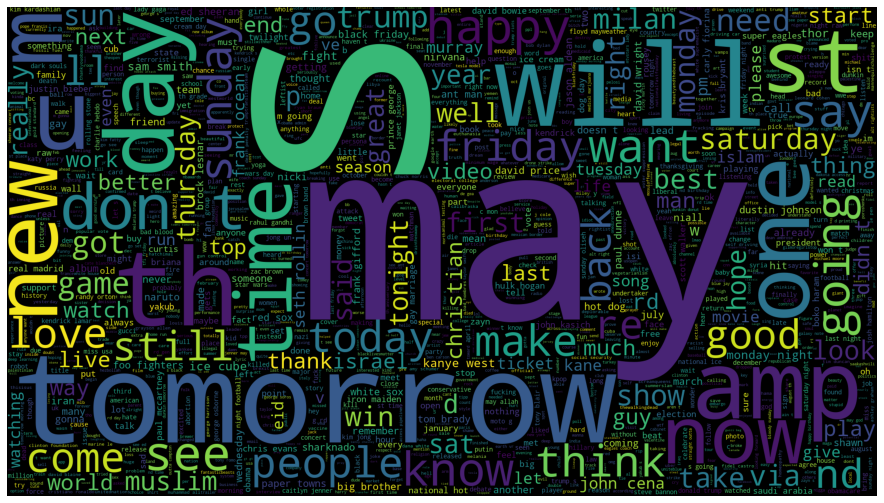

In [11]:
# start the wordcloud object here
wc = WordCloud(max_words=1500, width=1920, height=1080)

# a function to display and save a named word cloud
def showSaveWordCloud(text, filename):
    cloud = wc.generate(text)
    plt.figure(figsize= (16, 9), frameon=False)
    plt.axis('off')
    print(f'Word cloud for {filename}')
    plt.imshow(cloud)
    plt.savefig(f'../report/img/wc-{filename}.png', bbox_inches='tight')

# show and save the wc for train, test, all
# showSaveWordCloud(" ".join(train_df['text-clean-default']), 'train-clean-default')
# showSaveWordCloud(" ".join(test_df['text-clean-default']), 'test-clean-default')
showSaveWordCloud(" ".join(train_df['text-clean-default']) + " " + " ".join(test_df['text-clean-default']), 
    'all-clean-default')

# generate the wc for `positive`, `neutral` and `negative` instances only
for sentiment in set(train_df['sentiment']):
    showSaveWordCloud(" ".join(train_df['text-clean-default']),
    f'{sentiment}-clean-default')

In [12]:
# from these, construct a simple stopword list (the nltk list may be preferred)
DEFAULT_STOPWORDS = [
    'may', 's', 'll', 'u', 'will', 'one', 'st', 'th', 'the', 'm', 'amp', 'new', 
    't', 'don', 
]

# NLTK's stopword list may be more applicable
NLTK_STOPWORDS = stopwords.words()

# apply the cleaning with the different stopword lists
cleanConfig = DEFAULT_CLEAN_DICT.copy()
cleanConfig['stopwords'] = DEFAULT_STOPWORDS
train_df['text-clean-default-stopwords'] = train_df['text'].apply(lambda t: clean_tweet(t, cleanConfig))
test_df['text-clean-default-stopwords'] = test_df['text'].apply(lambda t: clean_tweet(t, cleanConfig))
cleanConfig['stopwords'] = NLTK_STOPWORDS
train_df['text-clean-nltk-stopwords'] = train_df['text'].apply(lambda t: clean_tweet(t, cleanConfig))
test_df['text-clean-nltk-stopwords'] = test_df['text'].apply(lambda t: clean_tweet(t, cleanConfig))

# compare the differences
train_df.sample(5)

KeyboardInterrupt: 

## 3. Vectorizers
Three transformers are going to be used `TfidfVectorizer`, `CountVectorizer` and `DictVectorizer`.

In [ ]:
# create a method to generate three bar graphs for top features in a vector based on their relative sums
def compare_bars(X, y, features, top_n=15):
    

## 4. Tokenization

## 5. Model Selection